# 平时作业-航班预测

完整的jupyter notebook可以访问我的Github仓库[地址]。

## 代码部分

首先为了简单评估模型的性能，我首先使用前120个数据来作为训练集，之后的作为测试集来进行测试。

同时测试分为两种，一种为完全由模型的预测来继续预测，另一种为每次给出真实值来进行预测。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

torch.manual_seed(1024)
%matplotlib inline

### 数据处理

In [2]:
file = pd.read_csv('data.csv', header=None)

data = file[1].values.astype(float) # 提取143条数据

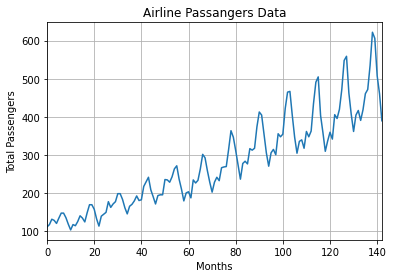

In [3]:
plt.title('Airline Passangers Data')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data)
plt.show()

接下来进行归一化操作

In [4]:
# 通过滑动窗口来创建数据
def sliding_windows(data, window_size):
    x = []
    y = []

    for i in range(len(data)-window_size):
        window_x = data[i:(i+window_size)]
        window_y = data[i+window_size]
        x.append(window_x)
        y.append(window_y)

    return np.array(x),np.array(y)

# 归一化操作
sc = MinMaxScaler(feature_range=(-1,1))
training_data = sc.fit_transform(data.reshape(-1,1))

window_size = 2
x, y = sliding_windows(training_data, window_size)

train_size = 120
test_size = len(y) - train_size

all_x = torch.Tensor(x)
all_y = torch.Tensor(y)

#用于推理144月乘客量
pred_x = torch.concat((all_x, torch.tensor(training_data[-2:]).unsqueeze(0))).float()

train_x = torch.Tensor(x[0:train_size])
train_y = torch.Tensor(y[0:train_size])

testX = torch.Tensor(x[train_size:len(x)])
testY = torch.Tensor(y[train_size:len(y)])

### 网络搭建

In [5]:
class RNN(nn.Module):

    def __init__(self, rnn_layer, seq_length):
        super(RNN, self).__init__()
        
        self.rnn = rnn_layer

        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.rnn.hidden_size*seq_length, 1)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.rnn.hidden_size*self.num_directions*seq_length, 1)
        
    def forward(self, x, state):
        
        # Propagate input through LSTM
        out, state = self.rnn(x, state)
        
        output = self.linear(out.reshape(out.size(0), -1))
        return output, state
    
    def begin_state(self, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.rnn.hidden_size))
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.rnn.hidden_size)),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.rnn.hidden_size)))

### 训练

这里统一使用了1000个epoch，然后hidden_size选择20，与实验课设置一致，多层RNN使用5层。

In [6]:
# Hyperparameters
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 20
num_layers = 5 # for multi-layer

criterion = nn.MSELoss()    # mean-squared error for regression

In [7]:
# 定义训练函数
def train(model, train_x, train_y, criterion, optimizer, num_epochs):
    state = model.begin_state(train_x.size(0))
    
    for epoch in range(num_epochs):
        outputs, _ = model(train_x, state)
        optimizer.zero_grad()

        # obtain the loss function
        loss = criterion(outputs, train_y)

        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



# 定义评估函数
def evaluate(model, all_x, all_y):
    model.eval()
    
    state = model.begin_state(all_x.size(0))
    train_predict, _= model(all_x, state)

    data_predict = train_predict.data.numpy()
    dataY_plot = all_y.data.numpy()

    data_predict = sc.inverse_transform(data_predict)
    dataY_plot = sc.inverse_transform(dataY_plot)
    plt.axvline(x=train_size, c='r', linestyle='--')
    
    plt.plot(dataY_plot)
    plt.plot(data_predict)
    plt.suptitle('Prediction')
    plt.show()

Epoch: 0, loss: 0.32453
Epoch: 100, loss: 0.01438
Epoch: 200, loss: 0.00928
Epoch: 300, loss: 0.00890
Epoch: 400, loss: 0.00870
Epoch: 500, loss: 0.00846
Epoch: 600, loss: 0.00821
Epoch: 700, loss: 0.00801
Epoch: 800, loss: 0.00787
Epoch: 900, loss: 0.00777
Epoch: 999, loss: 0.00769


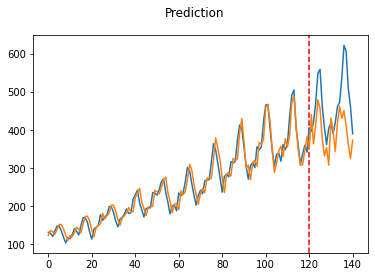

In [8]:
# 单层GRU
single_layer_gru = nn.GRU(input_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
single_layer_gru = RNN(single_layer_gru, window_size)

optimizer_1 = torch.optim.Adam(single_layer_gru.parameters(), lr=learning_rate)

# Train
train(single_layer_gru, train_x, train_y, criterion, optimizer_1, num_epochs)
# Eval    
evaluate(single_layer_gru, all_x, all_y)

Epoch: 0, loss: 0.22413
Epoch: 100, loss: 0.01399
Epoch: 200, loss: 0.00887
Epoch: 300, loss: 0.00861
Epoch: 400, loss: 0.00819
Epoch: 500, loss: 0.00808
Epoch: 600, loss: 0.00788
Epoch: 700, loss: 0.00796
Epoch: 800, loss: 0.00778
Epoch: 900, loss: 0.00777
Epoch: 999, loss: 0.00776


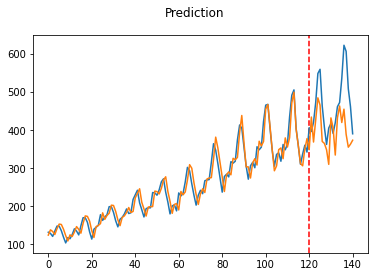

In [9]:
# 单层LSTM
single_layer_lstm = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
single_layer_lstm = RNN(single_layer_lstm, window_size)

optimizer_2 = torch.optim.Adam(single_layer_lstm.parameters(), lr=learning_rate)

# Train
train(single_layer_lstm, train_x, train_y, criterion, optimizer_2, num_epochs)
# Eval    
evaluate(single_layer_lstm, all_x, all_y)

Epoch: 0, loss: 0.39311
Epoch: 100, loss: 0.02005
Epoch: 200, loss: 0.00804
Epoch: 300, loss: 0.00741
Epoch: 400, loss: 0.00732
Epoch: 500, loss: 0.00713
Epoch: 600, loss: 0.00615
Epoch: 700, loss: 0.00605
Epoch: 800, loss: 0.00556
Epoch: 900, loss: 0.00516
Epoch: 999, loss: 0.00484


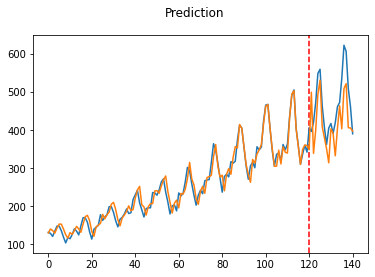

In [10]:
# 多层LSTM
multi_layer_lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=False, batch_first=True)
multi_layer_lstm = RNN(multi_layer_lstm, window_size)

optimizer_3 = torch.optim.Adam(multi_layer_lstm.parameters(), lr=learning_rate)

# Train
train(multi_layer_lstm, train_x, train_y, criterion, optimizer_3, num_epochs)
# Eval    
evaluate(multi_layer_lstm, all_x, all_y)

Epoch: 0, loss: 0.32710
Epoch: 100, loss: 0.01423
Epoch: 200, loss: 0.01083
Epoch: 300, loss: 0.00899
Epoch: 400, loss: 0.00883
Epoch: 500, loss: 0.00860
Epoch: 600, loss: 0.00812
Epoch: 700, loss: 0.00756
Epoch: 800, loss: 0.00745
Epoch: 900, loss: 0.00742
Epoch: 999, loss: 0.00740


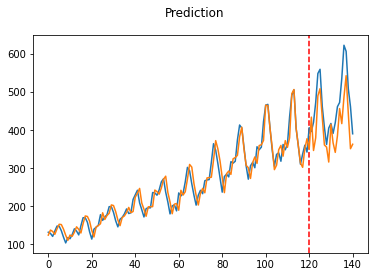

In [11]:
# 双向LSTM
single_layer__bidirection_lstm = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
single_layer__bidirection_lstm = RNN(single_layer__bidirection_lstm, window_size)

optimizer_4 = torch.optim.Adam(single_layer__bidirection_lstm.parameters(), lr=learning_rate)

# Train
train(single_layer__bidirection_lstm, train_x, train_y, criterion, optimizer_4, num_epochs)
# Eval    
evaluate(single_layer__bidirection_lstm, all_x, all_y)

Epoch: 0, loss: 0.36308
Epoch: 100, loss: 0.01298
Epoch: 200, loss: 0.00808
Epoch: 300, loss: 0.00758
Epoch: 400, loss: 0.00733
Epoch: 500, loss: 0.00668
Epoch: 600, loss: 0.00620
Epoch: 700, loss: 0.00601
Epoch: 800, loss: 0.00591
Epoch: 900, loss: 0.00584
Epoch: 999, loss: 0.00544


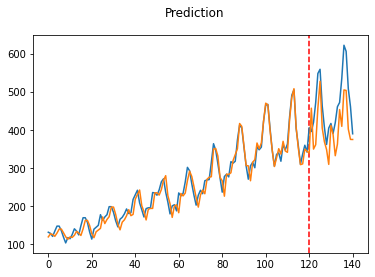

In [12]:
# 多层双向LSTM
multi_layer__bidirection_lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
multi_layer__bidirection_lstm = RNN(multi_layer__bidirection_lstm, window_size)

optimizer_5 = torch.optim.Adam(multi_layer__bidirection_lstm.parameters(), lr=learning_rate)

# Train
train(multi_layer__bidirection_lstm, train_x, train_y, criterion, optimizer_5, num_epochs)
# Eval    
evaluate(multi_layer__bidirection_lstm, all_x, all_y)

### 对全部数据集进行训练并预测

In [13]:
# 预测144月的结果
def predict(model, x):
    model.eval()
    state = model.begin_state(x.size(0))
    train_predict, _= model(x, state)

    data_predict = train_predict.data.numpy()

    data_predict = sc.inverse_transform(data_predict)
    
    print('Prediction of 144 month:', int(data_predict[-1][0]), 'passengers.')
    return data_predict

In [14]:
# 事实上是将全部数据又训练了200个epoch
num_epochs = 200

print('===single_layer_gru===')
train(single_layer_gru, all_x, all_y, criterion, optimizer_1, num_epochs)
prediction_1 = predict(single_layer_gru, pred_x)

print('===single_layer_lstm===')
train(single_layer_lstm, all_x, all_y, criterion, optimizer_2, num_epochs)
prediction_2 = predict(single_layer_lstm, pred_x)

print('===multi_layer_lstm===')
train(multi_layer_lstm, all_x, all_y, criterion, optimizer_3, num_epochs)
prediction_3 = predict(multi_layer_lstm, pred_x)

print('===single_layer__bidirection_lstm===')
train(single_layer__bidirection_lstm, all_x, all_y, criterion, optimizer_4, num_epochs)
prediction_4 = predict(single_layer__bidirection_lstm, pred_x)

print('===multi_layer__bidirection_lstm===')
train(multi_layer__bidirection_lstm, all_x, all_y, criterion, optimizer_5, num_epochs)
prediction_5 = predict(multi_layer__bidirection_lstm, pred_x)

===single_layer_gru===
Epoch: 0, loss: 0.02516
Epoch: 100, loss: 0.01127
Epoch: 199, loss: 0.01104
Prediction of 144 month: 332 passengers.
===single_layer_lstm===
Epoch: 0, loss: 0.02486
Epoch: 100, loss: 0.01093
Epoch: 199, loss: 0.01078
Prediction of 144 month: 331 passengers.
===multi_layer_lstm===
Epoch: 0, loss: 0.01517
Epoch: 100, loss: 0.00945
Epoch: 199, loss: 0.00859
Prediction of 144 month: 350 passengers.
===single_layer__bidirection_lstm===
Epoch: 0, loss: 0.01708
Epoch: 100, loss: 0.01043
Epoch: 199, loss: 0.01028
Prediction of 144 month: 340 passengers.
===multi_layer__bidirection_lstm===
Epoch: 0, loss: 0.01753
Epoch: 100, loss: 0.00808
Epoch: 199, loss: 0.00482
Prediction of 144 month: 341 passengers.


## 实验结果

|  模型   | 144月预测结果  |
|  :----:  | :----:  |
| 单层GRU  | 332 |
| 单层LSTM  | 331 |
| 多层LSTM  | 350 |
| 双向LSTM  | 340 |
| 多层双向LSTM  | 341 |